# Linear Models

In this notebook we will review linear models from `scikit-learn`.
We will :
- learn how to fit a simple linear model and interpret the coefficients;
- discuss feature augmentation to fit a non-linear function;
- use `LinearRegression` and its regularized version `Ridge` which is more
  robust;
- use `LogisticRegression` with `pipeline`;
- see examples of linear separability.

## 1. Regression

### The over-simplistic toy example
To illustrate the main principle of linear regression, we will use a dataset
that contains information about penguins.

In [1]:
import pandas as pd

data = pd.read_csv("../datasets/penguins.csv")
data.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,2007-11-11,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,2007-11-11,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,2007-11-16,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,2007-11-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,2007-11-16,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


This dataset contains measurements taken of penguins. We will formulate the
following problem: using the flipper length of a penguin, we would like
to infer its mass.

In [2]:
import seaborn as sns

feature_names = "Flipper Length (mm)"
target_name = "Body Mass (g)"

sns.scatterplot(data=data, x=feature_names, y=target_name)

# select the features of interest
X = data[[feature_names]].dropna()
y = data[target_name].dropna()

In this problem, penguin mass is our target. It is a continuous
variable that roughly varies between 2700 g and 6300 g. Thus, this is a
regression problem (in contrast to classification). We also see that there is
almost a linear relationship between the body mass of the penguin and the
flipper length. The longer the flipper, the heavier the penguin.

Thus, we could come up with a simple formula, where given a flipper length
we could compute the body mass of a penguin using a linear relationship of
of the form `y = a * x + b` where `a` and `b` are the 2 parameters of our
model.

In [3]:
def linear_model_flipper_mass(
    flipper_length, weight_flipper_length, intercept_body_mass
):
    """Linear model of the form y = a * x + b"""
    body_mass = weight_flipper_length * flipper_length + intercept_body_mass
    return body_mass

Using the model we defined above, we can check the body mass values
predicted for a range of flipper lengths. We will set `weight_flipper_length`
to be 45 and `intercept_body_mass` to be -5000.

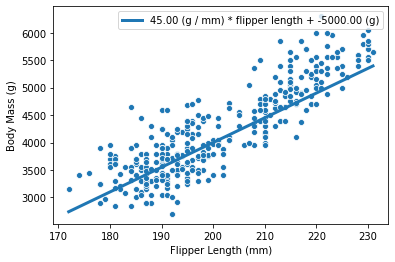

In [4]:
import matplotlib.pyplot as plt
import numpy as np


def plot_data_and_model(
    flipper_length_range, weight_flipper_length, intercept_body_mass,
    ax=None,
):
    """Compute and plot the prediction."""
    inferred_body_mass = linear_model_flipper_mass(
        flipper_length_range,
        weight_flipper_length=weight_flipper_length,
        intercept_body_mass=intercept_body_mass,
    )

    if ax is None:
        _, ax = plt.subplots()

    sns.scatterplot(data=data, x=feature_names, y=target_name, ax=ax)
    ax.plot(
        flipper_length_range,
        inferred_body_mass,
        linewidth=3,
        label=(
            f"{weight_flipper_length:.2f} (g / mm) * flipper length + "
            f"{intercept_body_mass:.2f} (g)"
        ),
    )
    plt.legend()


weight_flipper_length = 45
intercept_body_mass = -5000

flipper_length_range = np.linspace(X.min(), X.max(), num=300)
plot_data_and_model(
    flipper_length_range, weight_flipper_length, intercept_body_mass
)

The variable `weight_flipper_length` is a weight applied to the feature
`flipper_length` in
order to make the inference. When this coefficient is positive, it means that
penguins with longer flipper lengths will have larger body masses.
If the coefficient is negative, it means that penguins with shorter flipper
flipper lengths have larger body masses. Graphically, this coefficient is
represented by the slope of the curve in the plot. Below we show what the
curve would look like when the `weight_flipper_length` coefficient is
negative.

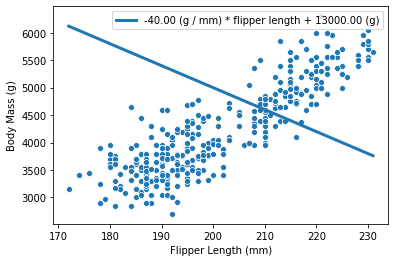

In [5]:
weight_flipper_length = -40
intercept_body_mass = 13000

flipper_length_range = np.linspace(X.min(), X.max(), num=300)
plot_data_and_model(
    flipper_length_range, weight_flipper_length, intercept_body_mass
)

In our case, this coefficient has a meaningful unit: g/mm.
For instance, a coefficient of 40 g/mm, means that for each
additional millimeter in flipper length, the body weight predicted will
increase by 40 g.

body_mass_180 = linear_model_flipper_mass(
    flipper_length=180, weight_flipper_length=40, intercept_body_mass=0
)
body_mass_181 = linear_model_flipper_mass(
    flipper_length=181, weight_flipper_length=40, intercept_body_mass=0
)

print(
    f"The body mass for a flipper length of 180 mm is {body_mass_180} g and "
    f"{body_mass_181} g for a flipper length of 181 mm"
)

We can also see that we have a parameter `intercept_body_mass` in our model.
This parameter corresponds to the value on the y-axis if `flipper_length=0`
(which in our case is only a mathematical consideration, as in our data,
 the value of `flipper_length` only goes from 170mm to 230mm). This y-value when  
x=0 is called the y-intercept. 
If `intercept_body_mass` is 0, the curve will
pass through the origin:

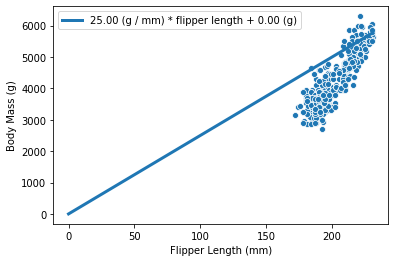

In [6]:
weight_flipper_length = 25
intercept_body_mass = 0

flipper_length_range = np.linspace(0, X.max(), num=300)
plot_data_and_model(
    flipper_length_range, weight_flipper_length, intercept_body_mass
)

Otherwise, it will pass through the `intercept_body_mass` value:

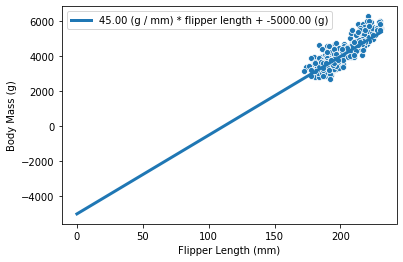

In [7]:
weight_flipper_length = 45
intercept_body_mass = -5000

flipper_length_range = np.linspace(0, X.max(), num=300)
plot_data_and_model(
    flipper_length_range, weight_flipper_length, intercept_body_mass
)

Now, that we understand how our model is inferring data, one should ask
how do we find the best value for the parameters. Indeed, it seems that we
can have many models, depending of the choice of parameters:

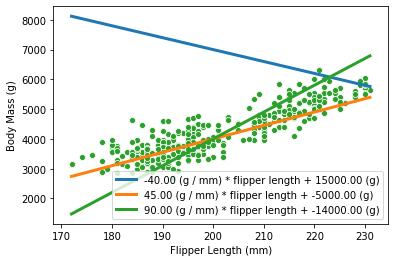

In [8]:
_, ax = plt.subplots()
flipper_length_range = np.linspace(X.min(), X.max(), num=300)
for weight, intercept in zip([-40, 45, 90], [15000, -5000, -14000]):
    plot_data_and_model(
        flipper_length_range, weight, intercept, ax=ax,
    )

To choose a model, we could use a metric that indicates how good our model is
at fitting our data.

In [9]:
from sklearn.metrics import mean_squared_error

for weight, intercept in zip([-40, 45, 90], [15000, -5000, -14000]):
    inferred_body_mass = linear_model_flipper_mass(
        X,
        weight_flipper_length=weight,
        intercept_body_mass=intercept,
    )
    model_error = mean_squared_error(y, inferred_body_mass)
    print(
        f"The following model \n "
        f"{weight:.2f} (g / mm) * flipper length + {intercept:.2f} (g) \n"
        f"has a mean squared error of: {model_error:.2f}"
    )

The following model 
 -40.00 (g / mm) * flipper length + 15000.00 (g) 
has a mean squared error of: 9366992.84
The following model 
 45.00 (g / mm) * flipper length + -5000.00 (g) 
has a mean squared error of: 184657.38
The following model 
 90.00 (g / mm) * flipper length + -14000.00 (g) 
has a mean squared error of: 489223.83


Thus, the best model will be the one with the lowest error.
Hopefully, this problem of finding the best parameters values
(i.e. that result in the lowest error)
can be solved without the need to check every
potential parameter combination. Indeed, this problem has a closed-form
solution: the best parameter values can be found by solving an equation. This
avoids the need for brute-force search. This strategy is
implemented in scikit-learn.

In [10]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X, y)

LinearRegression()

The instance `linear_regression` will store the parameter values in the
attributes `coef_` and `intercept_`. We can check what the optimal model
found is:

The error of the optimal model is 154546.19


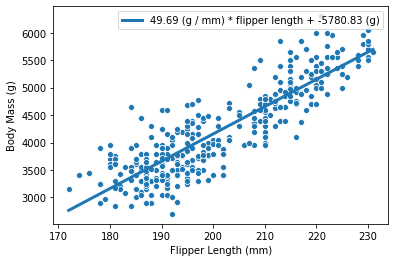

In [11]:
weight_flipper_length = linear_regression.coef_[0]
intercept_body_mass = linear_regression.intercept_

flipper_length_range = np.linspace(X.min(), X.max(), num=300)
plot_data_and_model(
    flipper_length_range, weight_flipper_length, intercept_body_mass
)

inferred_body_mass = linear_regression.predict(X)
model_error = mean_squared_error(y, inferred_body_mass)
print(f"The error of the optimal model is {model_error:.2f}")

### What if your data doesn't have a linear relationship
Now, we will define a new problem where the feature and the target are not
linearly linked. For instance, we could define `x` to be the years of
experience (normalized) and `y` the salary (normalized). Therefore, the
problem here would be to infer the salary given the years of experience.

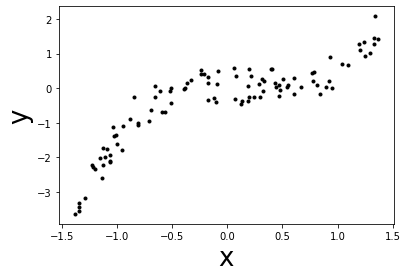

In [12]:
# data generation
# fix the seed for reproduction
rng = np.random.RandomState(0)

n_sample = 100
x_max, x_min = 1.4, -1.4
len_x = (x_max - x_min)
x = rng.rand(n_sample) * len_x - len_x/2
noise = rng.randn(n_sample) * .3
y = x ** 3 - 0.5 * x ** 2 + noise

# plot the data
plt.scatter(x, y,  color='k', s=9)
plt.xlabel('x', size=26)
_ = plt.ylabel('y', size=26)

### Exercise 1

In this exercise, you are asked to approximate the target `y` using a linear
function `f(x)`. i.e. find the best coefficients of the function `f` in order
to minimize the mean squared error. Here you shall find the coefficient manually
via trial and error (just as in the previous cells with weight and intercept).

Then you can compare the mean squared error of your model with the mean
squared error found by `LinearRegression` (which shall be the minimal one).

Mean squared error = 1.53


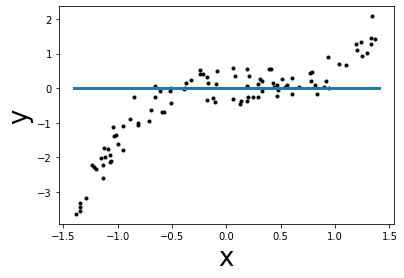

In [13]:
def f(x):
    intercept = 0  # TODO: update the parameters here
    weight = 0  # TODO: update the parameters here
    y_predict = weight * x + intercept
    return y_predict


# plot the slope of f
grid = np.linspace(x_min, x_max, 300)
plt.scatter(x, y, color='k', s=9)
plt.plot(grid, f(grid), linewidth=3)
plt.xlabel("x", size=26)
plt.ylabel("y", size=26)

mse = mean_squared_error(y, f(x))
print(f"Mean squared error = {mse:.2f}")

### Solution 1. by fiting a linear regression

Lowest mean squared error = 0.37


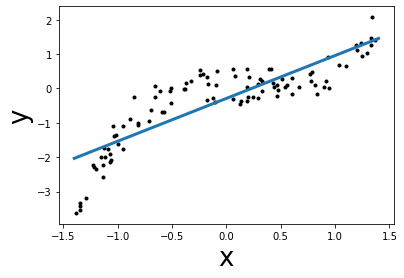

In [14]:
from sklearn import linear_model

linear_regression = linear_model.LinearRegression()
# X should be 2D for sklearn
X = x.reshape((-1, 1))
linear_regression.fit(X, y)

# plot the best slope
y_best = linear_regression.predict(grid.reshape(-1, 1))
plt.plot(grid, y_best, linewidth=3)
plt.scatter(x, y, color="k", s=9)
plt.xlabel("x", size=26)
plt.ylabel("y", size=26)

mse = mean_squared_error(y, linear_regression.predict(X))
print(f"Lowest mean squared error = {mse:.2f}")

Here the coefficients learnt by `LinearRegression` is the best curve that
fits the data. We can inspect the coefficients using the attributes of the
model learnt as follows:

In [15]:
print(
    f"best coef: w1 = {linear_regression.coef_[0]:.2f}, "
    f"best intercept: w0 = {linear_regression.intercept_:.2f}"
)

best coef: w1 = 1.25, best intercept: w0 = -0.29


It is important to note that the model learnt will not be able to handle
the non-linear relationship between `x` and `y` since linear models assume
the relationship between `x` and `y` to be linear. To obtain a better model,
we have 3 main solutions:

1. choose a model that natively can deal with non-linearity,
2. "augment" features by including expert knowledge which can be used by
   the model, or
2. use a "kernel" to have a locally-based decision function instead of a
   global linear decision function.

Let's illustrate quickly the first point by using a decision tree regressor
which can natively handle non-linearity.

Lowest mean squared error = 0.09


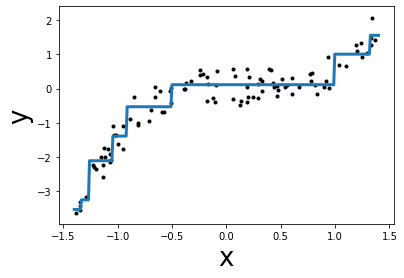

In [16]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3).fit(X, y)
y_pred = tree.predict(grid.reshape(-1, 1))

plt.plot(grid, y_pred, linewidth=3)
plt.scatter(x, y, color="k", s=9)
plt.xlabel("x", size=26)
plt.ylabel("y", size=26)

mse = mean_squared_error(y, tree.predict(X))
print(f"Lowest mean squared error = {mse:.2f}")

In this case, the model can handle non-linearity. Instead of having a model
which can natively deal with non-linearity, we could also modify our data: we
could create new features, derived from the original features, using some
expert knowledge. For instance, here we know that we have a cubic and squared
relationship between `x` and `y` (because we generated the data). Indeed,
we could create two new features (`x^2` and `x^3`) using this information.

Lowest mean squared error = 0.09


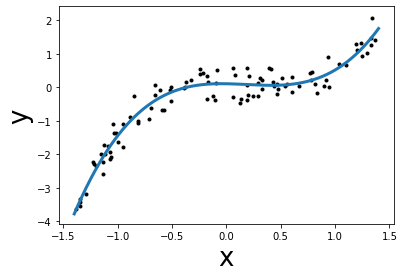

In [17]:
X = np.vstack([x, x ** 2, x ** 3]).T

linear_regression.fit(X, y)

grid_augmented = np.vstack([grid, grid ** 2, grid ** 3]).T
y_pred = linear_regression.predict(grid_augmented)

plt.plot(grid, y_pred, linewidth=3)
plt.scatter(x, y, color="k", s=9)
plt.xlabel("x", size=26)
plt.ylabel("y", size=26)

mse = mean_squared_error(y, linear_regression.predict(X))
print(f"Lowest mean squared error = {mse:.2f}")

We can see that even with a linear model, we can overcome the linearity
limitation of the model by adding the non-linear component into the design of
additional
features. Here, we created new feature by knowing the way the target was
generated. In practice, this is usually not the case. Instead, one is usually
creating interaction between features (e.g. $x_1 * x_2$) with different orders 
(e.g. $x_1, x_1^2, x_1^3$), at the risk of
creating a model with too much expressivity and which might overfit. In
scikit-learn, the `PolynomialFeatures` is a transformer to create such
feature interactions which we could have used instead of manually creating
new features.


To demonstrate `PolynomialFeatures`, we are going to use a scikit-learn
pipeline which will first create the new features and then fit the model.
We come back to scikit-learn pipelines and discuss them in more detail later.

Lowest mean squared error = 0.09


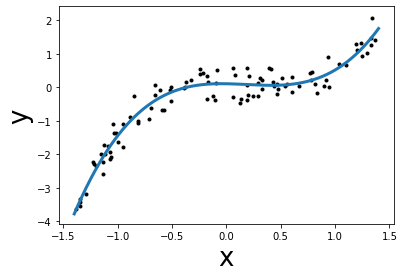

In [18]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

X = x.reshape(-1, 1)

model = make_pipeline(
    PolynomialFeatures(degree=3), LinearRegression()
)
model.fit(X, y)
y_pred = model.predict(grid.reshape(-1, 1))

plt.plot(grid, y_pred, linewidth=3)
plt.scatter(x, y, color="k", s=9)
plt.xlabel("x", size=26)
plt.ylabel("y", size=26)

mse = mean_squared_error(y, model.predict(X))
print(f"Lowest mean squared error = {mse:.2f}")

Thus, we saw that `PolynomialFeatures` is actually doing the same
operation that we did manually above.

**FIXME: it might be to complex to be introduced here but it seems good in
the flow. However, we go away from linear model.**

The last possibility to make a linear model more expressive is to use a
"kernel". Instead of learning a weight per feature as we previously
emphasized, a weight will be assign by sample instead. However, not all
samples will be used. This is the base of the support vector machine
algorithm.

Lowest mean squared error = 0.38


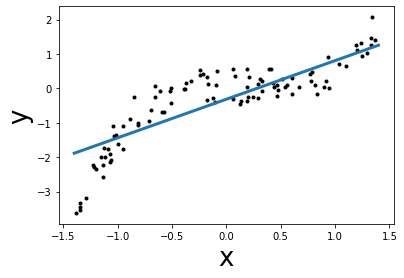

In [19]:
from sklearn.svm import SVR

svr = SVR(kernel="linear").fit(X, y)
y_pred = svr.predict(grid.reshape(-1, 1))

plt.plot(grid, y_pred, linewidth=3)
plt.scatter(x, y, color="k", s=9)
plt.xlabel("x", size=26)
plt.ylabel("y", size=26)

mse = mean_squared_error(y, svr.predict(X))
print(f"Lowest mean squared error = {mse:.2f}")

The algorithm can be modified such that it can use non-linear kernel. Then,
it will compute interaction between samples using this non-linear
interaction.

svr = SVR(kernel="poly", degree=3).fit(X, y)
y_pred = svr.predict(grid.reshape(-1, 1))

plt.plot(grid, y_pred, linewidth=3)
plt.scatter(x, y, color="k", s=9)
plt.xlabel("x", size=26)
plt.ylabel("y", size=26)

mse = mean_squared_error(y, svr.predict(X))
print(f"Lowest mean squared error = {mse:.2f}")

Therefore, kernel can make a model more expressive.

### Linear regression in higher dimension
In the previous example, we only used a single feature. But we have
already shown that we could add new feature to make the model more expressive
by deriving new features, based on the original feature.

Indeed, we could also use additional features (not related to the
original feature) and these could help us to predict the target.

We will load a dataset about house prices in California.
The dataset consists of 8 features regarding the demography and geography of
districts in California and the aim is to predict the median house price of
each district. We will use all 8 features to predict the target, median
house price.

In [20]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We will compare the score of `LinearRegression` and `Ridge` (which is a
regularized version of linear regression).

The scorer we will use to evaluate our model is the mean squared error, as in
the previous example. The lower the score, the better.

Here, we will divide our data into a training set, a validation set and a
testing set.
The validation set will be used to evaluate selection of the
hyper-parameters, while the testing set should only be used to calculate the
score of our final model.

In [21]:
from sklearn.model_selection import train_test_split

X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, random_state=1
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, random_state=1
)

Note that in the first example, we did not care about scaling our data in
order to keep the original units and have better intuition. However, it is
good practice to scale the data such that each feature has a similar standard
deviation. It will be even more important if the solver used by the model
is a gradient-descent-based solver.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit(X_train).transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

Scikit-learn provides several tools to preprocess the data. The
`StandardScaler` transforms the data such that each feature will have a mean
of zero and a standard deviation of 1.

This scikit-learn estimator is known as a transformer: it computes some
statistics (i.e the mean and the standard deviation) and stores them as
 attributes (scaler.mean_, scaler.scale_)
when calling `fit`. Using these statistics, it
transform the data when `transform` is called. Therefore, it is important to
note that `fit` should only be called on the training data, similar to
classifiers and regressors.

In [23]:
print('mean records on the training set:', scaler.mean_)
print('standard deviation records on the training set:', scaler.scale_)

mean records on the training set: [ 3.88516817e+00  2.85975022e+01  5.43642135e+00  1.09589237e+00
  1.42820345e+03  3.10666017e+00  3.56320086e+01 -1.19577850e+02]
standard deviation records on the training set: [1.90337997e+00 1.25434100e+01 2.37294735e+00 4.64651062e-01
 1.13564841e+03 1.26469009e+01 2.13361408e+00 2.00827882e+00]


In the example above, `X_train_scaled` is the data scaled, using the
mean and standard deviation of each feature, computed using the training
data `X_train`.

In [24]:
linear_regression = LinearRegression()
linear_regression.fit(X_train_scaled, y_train)
y_pred = linear_regression.predict(X_valid_scaled)
print(
    f"Mean squared error on the validation set: "
    f"{mean_squared_error(y_valid, y_pred):.4f}"
)

Mean squared error on the validation set: 0.5085


Instead of calling the transformer to transform the data and then calling
the regressor, scikit-learn provides a `Pipeline`, which 'chains' the
transformer and regressor together. The pipeline allows you to use a
sequence of transformer(s) followed by a regressor or a classifier, in one
call. (i.e. fitting the pipeline will fit both the transformer(s) and the regressor. 
Then predicting from the pipeline will first transform the data through the transformer(s)
then predict with the regressor from the transformed data)

This pipeline exposes the same API as the regressor and classifier
and will manage the calls to `fit` and `transform` for you, avoiding any
problems with data leakage (when knowledge of the test data was 
inadvertently included in training a model, as when fitting a transformer
on the test data).

We already presented `Pipeline` in the second notebook and we will use it
here to combine both the scaling and the linear regression.

We will can create a `Pipeline` by using `make_pipeline` and giving as
arguments the transformation(s) to be performed (in order) and the regressor
model.

So the two cells above can be reduced to this new one:

In [25]:
from sklearn.pipeline import make_pipeline

linear_regression = make_pipeline(StandardScaler(), LinearRegression())

linear_regression.fit(X_train, y_train)
y_pred_valid = linear_regression.predict(X_valid)
linear_regression_score = mean_squared_error(y_valid, y_pred_valid)
y_pred_test = linear_regression.predict(X_test)

print(
    f"Mean squared error on the validation set: "
    f"{mean_squared_error(y_valid, y_pred_valid):.4f}"
)
print(
    f"Mean squared error on the test set: "
    f"{mean_squared_error(y_test, y_pred_test):.4f}"
)

Mean squared error on the validation set: 0.5085
Mean squared error on the test set: 0.5361


Now we want to compare this basic `LinearRegression` versus its regularized
form `Ridge`.

We will tune the parameter `alpha` in `Ridge` and compare the results with
the `LinearRegression` model which is not regularized.

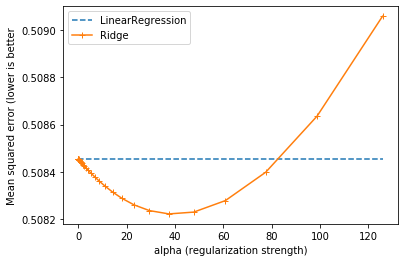

In [26]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(StandardScaler(), Ridge())

list_alphas = np.logspace(-2, 2.1, num=40)
list_ridge_scores = []
for alpha in list_alphas:
    ridge.set_params(ridge__alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_valid)
    list_ridge_scores.append(mean_squared_error(y_valid, y_pred))

plt.plot(
    list_alphas, [linear_regression_score] * len(list_alphas), '--',
    label='LinearRegression',
)
plt.plot(list_alphas, list_ridge_scores, "+-", label='Ridge')
plt.xlabel('alpha (regularization strength)')
plt.ylabel('Mean squared error (lower is better')
_ = plt.legend()

We see that, just like adding salt in cooking, adding regularization in our
model could improve its error on the validation set. But too much
regularization, like too much salt, decreases its performance.

We can see visually that the best `alpha` should be around 40.

In [27]:
best_alpha = list_alphas[np.argmin(list_ridge_scores)]
best_alpha

37.528307143701745

Note that, we selected this alpha *without* using the testing set ; but
instead by using the validation set which is a subset of the training
data. This is so we do not "overfit" the test data and
can be seen in the lesson *basic hyper-parameters tuning*.
We can finally compare the performance of the `LinearRegression` model to the
best `Ridge` model, on the testing set.

In [28]:
print("Linear Regression")
y_pred_test = linear_regression.predict(X_test)
print(
    f"Mean squared error on the test set: "
    f"{mean_squared_error(y_test, y_pred_test):.4f}"
)

print("Ridge Regression")
ridge.set_params(ridge__alpha=alpha)
ridge.fit(X_train, y_train)
y_pred_test = ridge.predict(X_test)
print(
    f"Mean squared error on the test set: "
    f"{mean_squared_error(y_test, y_pred_test):.4f}"
)
# FIXME add explication why Ridge is not better (equivalent) than linear 
# regression here.

Linear Regression
Mean squared error on the test set: 0.5361
Ridge Regression
Mean squared error on the test set: 0.5367


The hyper-parameter search could have been made using `GridSearchCV`
instead of manually splitting the training data (into training and
validation subsets) and selecting the best alpha.

In [29]:
from sklearn.model_selection import GridSearchCV

ridge = GridSearchCV(
    make_pipeline(StandardScaler(), Ridge()),
    param_grid={"ridge__alpha": list_alphas},
)
ridge.fit(X_train_valid, y_train_valid)
print(ridge.best_params_)

{'ridge__alpha': 23.126108778270584}


The `GridSearchCV` tests all possible given `alpha` values and picks
the best one with a cross-validation scheme. We can now compare with
`LinearRegression`.

In [30]:
print("Linear Regression")
linear_regression.fit(X_train_valid, y_train_valid)
y_pred_test = linear_regression.predict(X_test)
print(
    f"Mean squared error on the test set: "
    f"{mean_squared_error(y_test, y_pred_test):.4f}"
)

print("Ridge Regression")
y_pred_test = ridge.predict(X_test)
print(
    f"Mean squared error on the test set: "
    f"{mean_squared_error(y_test, y_pred_test):.4f}"
)

Linear Regression
Mean squared error on the test set: 0.5357
Ridge Regression
Mean squared error on the test set: 0.5355


It is also interesting to know that several regressors and classifiers
in scikit-learn are optimized to make this parameter tuning. They usually
finish with the term "CV" for "Cross Validation" (e.g. `RidgeCV`).
They are more efficient than using `GridSearchCV` and you should use them
instead.

We will repeat the equivalent of the hyper-parameter search but instead of
using a `GridSearchCV`, we will use `RidgeCV`.

In [31]:
from sklearn.linear_model import RidgeCV

ridge = make_pipeline(
    StandardScaler(), RidgeCV(alphas=[.1, .5, 1, 5, 10, 50, 100])
)
ridge.fit(X_train_valid, y_train_valid)
ridge[-1].alpha_

50.0

In [32]:
print("Linear Regression")
y_pred_test = linear_regression.predict(X_test)
print(
    f"Mean squared error on the test set: "
    f"{mean_squared_error(y_test, y_pred_test):.4f}"
)

print("Ridge Regression")
y_pred_test = ridge.predict(X_test)
print(
    f"Mean squared error on the test set: "
    f"{mean_squared_error(y_test, y_pred_test):.4f}"
)

Linear Regression
Mean squared error on the test set: 0.5357
Ridge Regression
Mean squared error on the test set: 0.5355


Note that the best hyper-parameter value is different because the
cross-validation used in the different approach is internally different.

## 2. Classification
In regression, we saw that the target to be predicted was a continuous
variable. In classification, this target will be discrete (e.g. categorical).

We will go back to our penguin dataset. However, this time we will try to
predict the penguin species using the culmen information. We will also
simplify our classification problem by selecting only 2 of the penguin
species to solve a binary classification problem.

In [33]:
data = pd.read_csv("../datasets/penguins.csv")

# select the features of interest
culmen_columns = ["Culmen Length (mm)", "Culmen Depth (mm)"]
target_column = "Species"

data = data[culmen_columns + [target_column]]
data[target_column] = data[target_column].str.split().str[0]
data = data[data[target_column].apply(lambda x: x in ("Adelie", "Chinstrap"))]
data = data.dropna()

We can quickly start by visualizing the feature distribution by class:

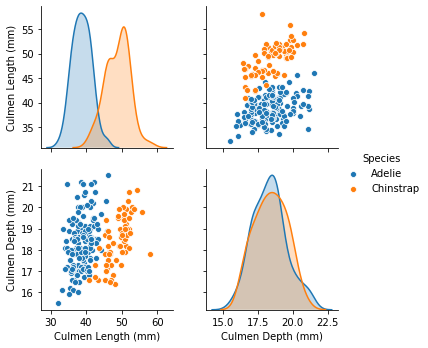

In [34]:
_ = sns.pairplot(data=data, hue="Species")

We can observe that we have quite a simple problem. When the culmen
length increases, the probability that the penguin is a Chinstrap is closer
to 1. However, the culmen depth is not helpful for predicting the penguin
species.

For model fitting, we will separate the target from the data and
we will create a training and a testing set.

In [35]:
from sklearn.model_selection import train_test_split

X, y = data[culmen_columns], data[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0,
)

To visualize the separation found by our classifier, we will define an helper
function `plot_decision_function`. In short, this function will fit our
classifier and plot the edge of the decision function, where the probability
to be an Adelie or Chinstrap will be equal (p=0.5).

In [36]:
def plot_decision_function(X, y, clf, title="auto", ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    clf.fit(X, y)

    # create a grid to evaluate all possible samples
    plot_step = 0.02
    feature_0_min, feature_0_max = (
        X.iloc[:, 0].min() - 1,
        X.iloc[:, 0].max() + 1,
    )
    feature_1_min, feature_1_max = (
        X.iloc[:, 1].min() - 1,
        X.iloc[:, 1].max() + 1,
    )
    xx, yy = np.meshgrid(
        np.arange(feature_0_min, feature_0_max, plot_step),
        np.arange(feature_1_min, feature_1_max, plot_step),
    )

    # compute the associated prediction
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4)
    sns.scatterplot(
        data=pd.concat([X, y], axis=1),
        x=X.columns[0],
        y=X.columns[1],
        hue=y.name,
        ax=ax,
    )
    if title == "auto":
        C = clf[-1].C if hasattr(clf[-1], "C") else clf[-1].C_
        ax.set_title(f"C={C}\n with coef={clf[-1].coef_[0]}")
    else:
        ax.set_title(title)

### Un-penalized logistic regression

The linear regression that we previously saw will predict a continuous
output. When the target is a binary outcome, one can use the logistic
function to model the probability. This model is known as logistic
regression.

Scikit-learn provides the class `LogisticRegression` which implements this
algorithm.

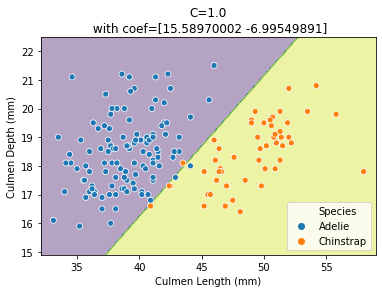

In [37]:
from sklearn.linear_model import LogisticRegression

logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegression(penalty="none")
)
plot_decision_function(X_train, y_train, logistic_regression)

Thus, we see that our decision function is represented by a line separating
the 2 classes. Since the line is oblique, it means that we used a
combination of both features:

In [38]:
print(logistic_regression[-1].coef_)

[[15.58970002 -6.99549891]]


Indeed, both coefficients are non-null.

### Apply some regularization when fitting the logistic model

The `LogisticRegression` model allows one to apply regularization via the
parameter `C`. It would be equivalent to shifting from `LinearRegression`
to `Ridge`. Ccontrary to `Ridge`, the value of the
`C` parameter is inversely proportional to the regularization strength:
a smaller `C` will lead to a more regularized model. We can check the effect
of regularization on our model:

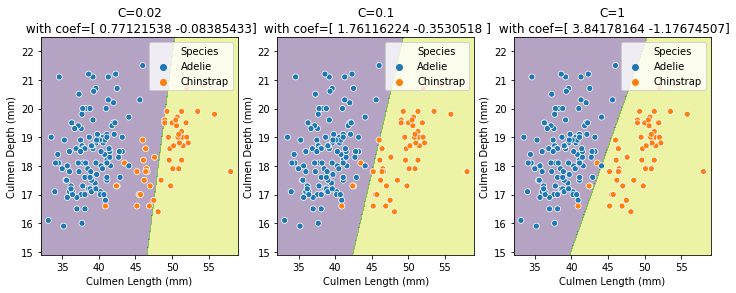

In [39]:
_, axs = plt.subplots(ncols=3, figsize=(12, 4))

for ax, C in zip(axs, [0.02, 0.1, 1]):
    logistic_regression = make_pipeline(
        StandardScaler(), LogisticRegression(C=C)
    )
    plot_decision_function(
        X_train, y_train, logistic_regression, ax=ax,
    )

A more regularized model will make the coefficients tend to 0. Since one of
the features is considered less important when fitting the model (lower
coefficient magnitude), only one of the feature will be used when C is small.
This feature is the culmen length which is in line with our first insight
when plotting the marginal feature probabilities.

Just like the `RidgeCV` class which automatically finds the optimal `alpha`,
one can use `LogisticRegressionCV` to find the best `C` on the training data.

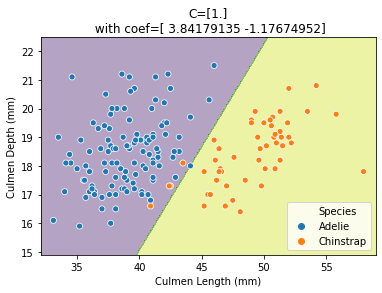

In [40]:
from sklearn.linear_model import LogisticRegressionCV

logistic_regression = make_pipeline(
    StandardScaler(), LogisticRegressionCV(Cs=[0.01, 0.1, 1, 10])
)
plot_decision_function(X_train, y_train, logistic_regression)

### Beyond linear separation

As we saw in regression, the linear classification model expects the data
to be linearly separable. When this assumption does not hold, the model
is not expressive enough to properly fit the data. One needs to apply the
same tricks as in regression: feature augmentation (potentially using
expert-knowledge) or using a kernel based method.

We will provide examples where we will use a kernel support vector machine
to perform classification on some toy-datasets where it is impossible to
find a perfect linear separation.

In [41]:
from sklearn.datasets import (
    make_moons, make_classification, make_gaussian_quantiles,
)

X_moons, y_moons = make_moons(n_samples=500, noise=.13, random_state=42)
X_class, y_class = make_classification(
    n_samples=500, n_features=2, n_redundant=0, n_informative=2,
    random_state=2,
)
X_gauss, y_gauss = make_gaussian_quantiles(
    n_samples=50, n_features=2, n_classes=2, random_state=42,
)

datasets = [
    [pd.DataFrame(X_moons, columns=["Feature #0", "Feature #1"]),
     pd.Series(y_moons, name="class")],
    [pd.DataFrame(X_class, columns=["Feature #0", "Feature #1"]),
     pd.Series(y_class, name="class")],
    [pd.DataFrame(X_gauss, columns=["Feature #0", "Feature #1"]),
     pd.Series(y_gauss, name="class")],
]

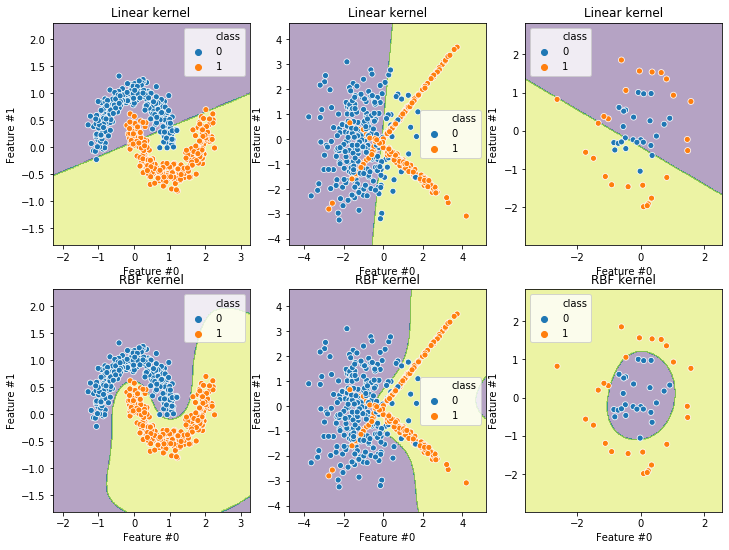

In [42]:
from sklearn.svm import SVC

_, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 9))

linear_model = make_pipeline(StandardScaler(), SVC(kernel="linear"))
kernel_model = make_pipeline(StandardScaler(), SVC(kernel="rbf"))

for ax, (X, y) in zip(axs[0], datasets):
    plot_decision_function(X, y, linear_model, title="Linear kernel", ax=ax)
for ax, (X, y) in zip(axs[1], datasets):
    plot_decision_function(X, y, kernel_model, title="RBF kernel", ax=ax)

We see that the $R^2$ score decreases on each dataset, so we can say that each
dataset is "less linearly separable" than the previous one.

# Main take away

- `LinearRegression` find the best slope which minimize the mean squared
  error on the train set
- `Ridge` could be better on the test set, thanks to its regularization
- `RidgeCV` and `LogisiticRegressionCV` find the best relugarization thanks
  to cross validation on the training data
- `pipeline` can be used to combinate a scaler and a model
- If the data are not linearly separable, we shall use a more complex model
  or use feature augmentation